# IMDB Names dataset embedding


## install libs

In [22]:
!pip install -U sentence-transformers

In [23]:
!pip install umap-learn


## Import dataset

In [25]:
import pandas as pd
import requests
import gzip
import shutil

# IMDb names dataset URL
names_url = "https://datasets.imdbws.com/name.basics.tsv.gz"
file_name = "name.basics.tsv.gz"

# Download the dataset
response = requests.get(names_url, stream=True)
with open(file_name, "wb") as file:
    shutil.copyfileobj(response.raw, file)

# Extract the dataset
!gzip -d $file_name --force

# Load the tsv file into a pandas DataFrame
df = pd.read_csv(file_name.replace(".gz", ""), sep='\t')

# Display the first few rows of the DataFrame
print(df.head())


      nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                     primaryProfession  \
0       soundtrack,actor,miscellaneous   
1                   actress,soundtrack   
2  actress,soundtrack,music_department   
3              actor,soundtrack,writer   
4                writer,director,actor   

                            knownForTitles  
0  tt0053137,tt0045537,tt0050419,tt0072308  
1  tt0117057,tt0075213,tt0038355,tt0037382  
2  tt0056404,tt0054452,tt0049189,tt0057345  
3  tt0072562,tt0080455,tt0078723,tt0077975  
4  tt0083922,tt0050976,tt0069467,tt0050986  


In [26]:
df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0045537,tt0050419,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0075213,tt0038355,tt0037382"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0054452,tt0049189,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0072562,tt0080455,tt0078723,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0083922,tt0050976,tt0069467,tt0050986"
...,...,...,...,...,...,...
12743168,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt14069590,tt2455546,tt11657662"
12743169,nm9993716,Essias Loberg,\N,\N,NaN,\N
12743170,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
12743171,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [27]:
df_base = df.copy(deep=True)

## compute embeddings

Lets take a 1M sample.

In [28]:
df = df_base.sample(n=10000)

In [29]:
df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
8886647,nm5147624,Maria Vouza,\N,\N,"assistant_director,editor,director","tt3188946,tt3101322,tt2340076,tt2167819"
11337908,nm8265968,Luigi Squeegee,\N,\N,actor,"tt5860022,tt11378830"
3794775,nm13030986,Tomohiro Kita,\N,\N,"composer,music_department","tt8652818,tt3432596,tt12879624,tt6035642"
4187530,nm13447821,Carlos,\N,\N,actor,\N
3037966,nm12224568,Brandon Barrows,\N,\N,"editor,cinematographer",tt3458612


In [30]:
len(df)

10000

## option: keep family name only

And backup `primaryName` to `completeName`.

In [31]:
df['completeName'] = df['primaryName']
df['primaryName'] = df['primaryName'].str.split(' ').str.get(1)

### install and test model

In [32]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
# print(embeddings)

In [33]:
embeddings.shape

(2, 384)

### compute embeddings

In [39]:
embeddings = model.encode(df.primaryName.astype(str).values, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [40]:
embeddings.shape

(10000, 384)

## PCA

It is fast but explained variance for 10 dimensions is 0.035, which is too low to represent the underlying 384 dimensions.


In [41]:
embeddings

array([[-0.06223736,  0.06476343, -0.10970946, ..., -0.04030181,
         0.01488711, -0.02668505],
       [ 0.01936471, -0.03786838,  0.05480148, ..., -0.0335632 ,
         0.06756133,  0.06862034],
       [-0.03365364,  0.08782411, -0.07903105, ..., -0.06426375,
        -0.06296527, -0.05787385],
       ...,
       [ 0.00165157,  0.05589168,  0.07660324, ...,  0.07567637,
         0.05721202, -0.01767359],
       [-0.09359413, -0.0395004 , -0.09631554, ..., -0.01565736,
        -0.00229395, -0.07816653],
       [-0.05074568, -0.04546517,  0.00440615, ..., -0.0899769 ,
        -0.01117349,  0.13373943]], dtype=float32)

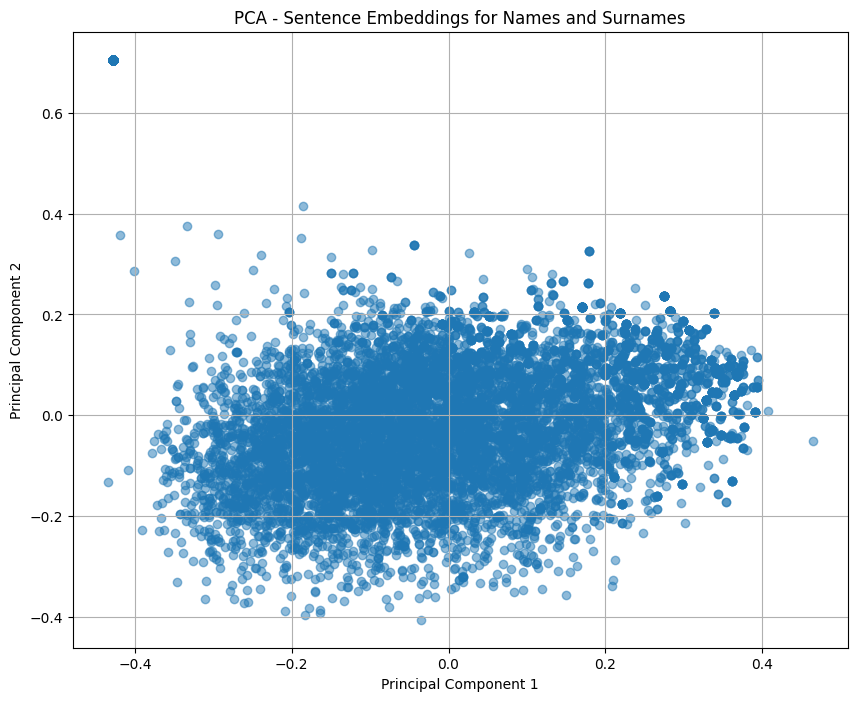

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# Replace this with your 'embeddings' data (300+ dimensional vectors for 10k names)
# For demonstration purposes, I'm using random embeddings of shape (10000, 384)
# embeddings = np.random.rand(10000, 384)

# Perform PCA
pca = PCA(n_components=2)  # Set n_components to the desired number of dimensions (e.g., 2 for 2D visualization)
reduced_embeddings = pca.fit_transform(embeddings)

# Convert the reduced embeddings to a DataFrame for visualization
df_reduced = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(df_reduced['Component 1'], df_reduced['Component 2'], alpha=0.5)
plt.title('PCA - Sentence Embeddings for Names and Surnames')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [43]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# Replace this with your 'embeddings' data (300+ dimensional vectors for 10k names)
# For demonstration purposes, I'm using random embeddings of shape (10000, 384)
# embeddings = np.random.rand(10000, 384)

explained_var_ratios = []
for n_components in range(2, 11):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    explained_var_ratios.append(np.sum(pca.explained_variance_ratio_))

# Print the explained variance ratios for each dimension from 2D to 10D
for n, explained_var_ratio in enumerate(explained_var_ratios, start=2):
    print(f"Explained Variance Ratio for {n}D: {explained_var_ratio:.4f}")


Explained Variance Ratio for 2D: 0.0788
Explained Variance Ratio for 3D: 0.1043
Explained Variance Ratio for 4D: 0.1268
Explained Variance Ratio for 5D: 0.1464
Explained Variance Ratio for 6D: 0.1643
Explained Variance Ratio for 7D: 0.1795
Explained Variance Ratio for 8D: 0.1946
Explained Variance Ratio for 9D: 0.2087
Explained Variance Ratio for 10D: 0.2224


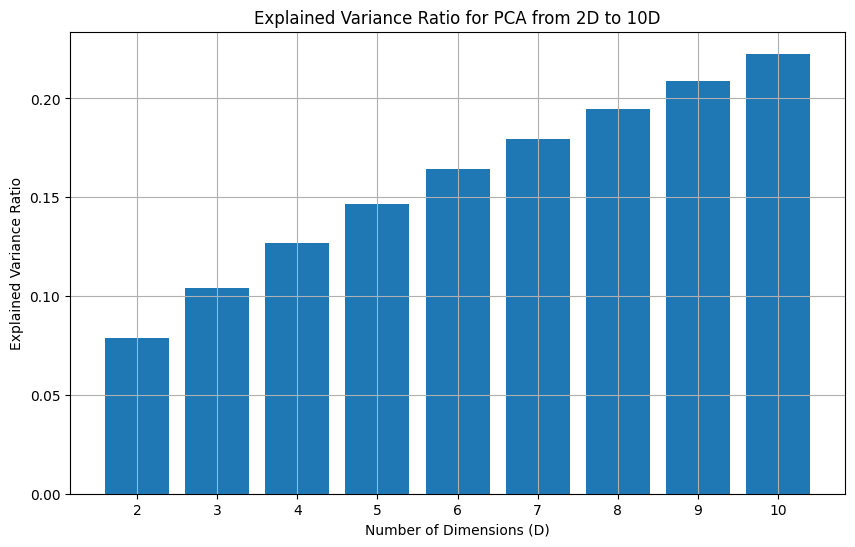

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# Replace this with your 'embeddings' data (300+ dimensional vectors for 10k names)
# For demonstration purposes, I'm using random embeddings of shape (10000, 384)
# embeddings = np.random.rand(10000, 384)

explained_var_ratios = []
for n_components in range(2, 11):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    explained_var_ratios.append(np.sum(pca.explained_variance_ratio_))

# Plot the explained variance ratios in a bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(2, 11), explained_var_ratios)
plt.xlabel('Number of Dimensions (D)')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for PCA from 2D to 10D')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()


## UMAP

We find out that umap make a large blob. Not useful.

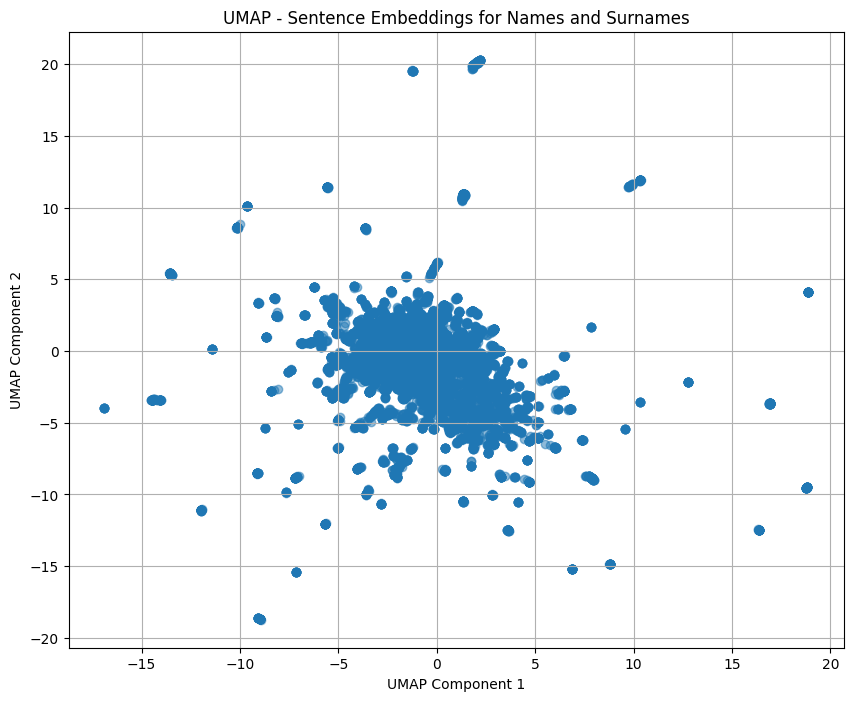

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import umap

# Replace this with your 'embeddings' data (300+ dimensional vectors for 10k names)
# For demonstration purposes, I'm using random embeddings of shape (10000, 384)
# embeddings = np.random.rand(10000, 384)

# Perform UMAP
umap_model = umap.UMAP(n_components=2)  # Set n_components to the desired number of dimensions (e.g., 2 for 2D visualization)
reduced_embeddings = umap_model.fit_transform(embeddings)

# Convert the reduced embeddings to a DataFrame for visualization
df_reduced = pd.DataFrame(reduced_embeddings, columns=['UMAP Component 1', 'UMAP Component 2'])

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(df_reduced['UMAP Component 1'], df_reduced['UMAP Component 2'], alpha=0.5)
plt.title('UMAP - Sentence Embeddings for Names and Surnames')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()


In [46]:
df_reduced

,UMAP Component 1,UMAP Component 2
0,-3.585629,-1.384704
1,-1.100891,0.050885
2,-1.300972,0.222782
3,2.196800,20.278883
4,2.493134,-3.128299
...,...,...
9995,1.938871,-4.245210
9996,-1.331738,-6.860646
9997,0.645440,0.713836
9998,6.463074,-2.763098


In [47]:
df_reduced

,UMAP Component 1,UMAP Component 2
0,-3.585629,-1.384704
1,-1.100891,0.050885
2,-1.300972,0.222782
3,2.196800,20.278883
4,2.493134,-3.128299
...,...,...
9995,1.938871,-4.245210
9996,-1.331738,-6.860646
9997,0.645440,0.713836
9998,6.463074,-2.763098


## Export UMAP dataset

In [48]:
df.reset_index(drop=True, inplace=True)

In [49]:
df_to_export = pd.merge(df, df_reduced, left_index=True, right_index=True)

In [50]:
df_to_export.to_csv('dimensions_ummap_v1.csv')

## TSNE

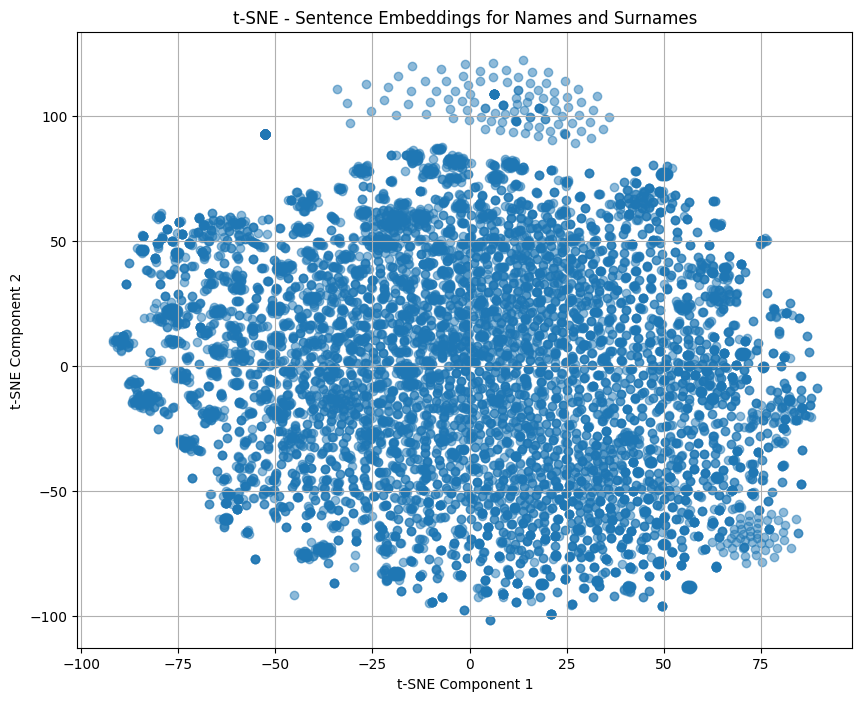

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE

# Replace this with your 'embeddings' data (300+ dimensional vectors for 10k names)
# For demonstration purposes, I'm using random embeddings of shape (10000, 384)
# embeddings = np.random.rand(10000, 384)

# Perform t-SNE
tsne_model = TSNE(n_components=2, random_state=42)  # Set n_components to the desired number of dimensions (e.g., 2 for 2D visualization)
reduced_embeddings = tsne_model.fit_transform(embeddings)

# Convert the reduced embeddings to a DataFrame for visualization
df_reduced = pd.DataFrame(reduced_embeddings, columns=['t-SNE Component 1', 't-SNE Component 2'])

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(df_reduced['t-SNE Component 1'], df_reduced['t-SNE Component 2'], alpha=0.5)
plt.title('t-SNE - Sentence Embeddings for Names and Surnames')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


In [52]:
df_to_export = pd.merge(df, df_reduced, left_index=True, right_index=True)
df_to_export.to_csv('dimensions_tsne_v1.csv')